In [1]:
from collections import defaultdict
import math
import queue
from pprint import pprint
from IPython.core.debugger import set_trace
import warnings
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torchvision.datasets as datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import Compose

from src.classification.models.alexnet import AlexNet
from src.classification.models.vgg import VGGBlock, make_vgg_11_a
from src.classification.predictor import ClassificationPredictor
from src.classification.train import fit
from src.classification.plot import plot_classifications
from src.transform import to_numpy, to_rgb, to_torch, resize
from src.misc import plot_summary, transpose_history

In [2]:
from src.classification.module import ClassificationModule
from src.classification.dataset import ClassificationDataset

In [3]:
from light_torch.module.base import Module
from light_torch.train import Trainer
from light_torch.data import Dataset

## Model

### Create Model

In [21]:
alexnet = AlexNet(10)

In [22]:
cuda = torch.device("cuda:0")
alexnet = alexnet.to(cuda)

## Dataset 

### Define Transforms

In [23]:
img_transform = Compose([
    to_numpy,
    to_rgb,
    resize, 
    to_torch,
])

### Create Dataset

In [24]:
class MnistDataset(ClassificationDataset):
    def __init__(self, train_batch_size=32, val_batch_size=64):
        super().__init__()
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        
        self.mnist_testset = datasets.MNIST(
            root='./resources/classification/', 
            train=False, 
            download=True, 
            transform=img_transform,
        )
        self.mnist_trainset = datasets.MNIST(
            root='./resources/classification/', 
            train=True, 
            download=True, 
            transform=img_transform,
        )
                 
    def get_train_data(self):
        return DataLoader(
            self.mnist_trainset,
            batch_size=self.train_batch_size,
        )
    
    def get_test_data(self):
        pass
    
    def get_val_data(self):
        return DataLoader(
            self.mnist_testset,
            batch_size=self.val_batch_size,
        )
    
    def num_to_label(self, num):
        if 0 <= num <= 9:
            return str(num)
        raise ValueError(
            f"`num` expected to be in range [0, 9]. Actual value {num}"
        )
    
    def label_to_num(self, label: str):
        if len(label) > 1:
            raise ValueError("label expected to have length 1")
            
        if "0" <= label <= "9":
            return int(label)
        
        raise ValueError(
            f"`label` expected to be in range ['0', '9']. Actual value {label}"
        )
    
    def get_label_num(self):
        return 10

In [25]:
mnist_dataset = MnistDataset()

### Create Dataloader

In [26]:
mnist_trainset = mnist_dataset.mnist_trainset

In [27]:
def to_visualizable(tensor_img):
    return tensor_img.numpy().astype(np.uint8).transpose((1, 2, 0))

Text(0.5, 1.0, '5')

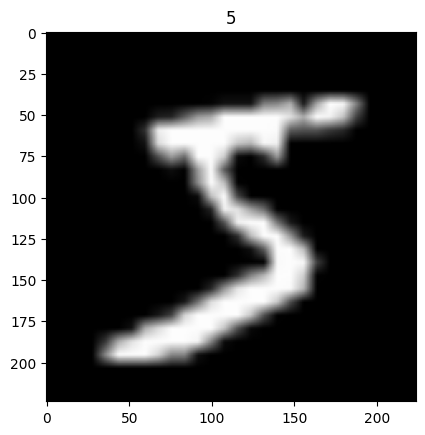

In [28]:
plt.figure()
img, label = mnist_trainset[0]
plt.imshow(to_visualizable(img))
plt.title(label)

In [29]:
criterion = nn.CrossEntropyLoss()

In [30]:
label_mapper = {str(idd): idd for idd in range(10)}

In [31]:
classification_module = ClassificationModule(
    alexnet, 
    criterion, 
    label_mapper,
    softmax=False
)

## Train

In [32]:
trainer = Trainer(module=classification_module)

In [33]:
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.001)

In [34]:
trainer.fit(
    optimizer, 
    10, 
    mnist_dataset.get_train_data(), 
    val_data=mnist_dataset.get_val_data(),
)

Train epoch  001:   0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
clas

In [35]:
trainer.history

[]

## Prediction

In [14]:
alexnext_predictor = ClassificationPredictor(model=alexnet)

In [15]:
imgs, gt_labels = next(iter(test_dl))

In [16]:
pred_labels = alexnext_predictor(imgs.to(cuda))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

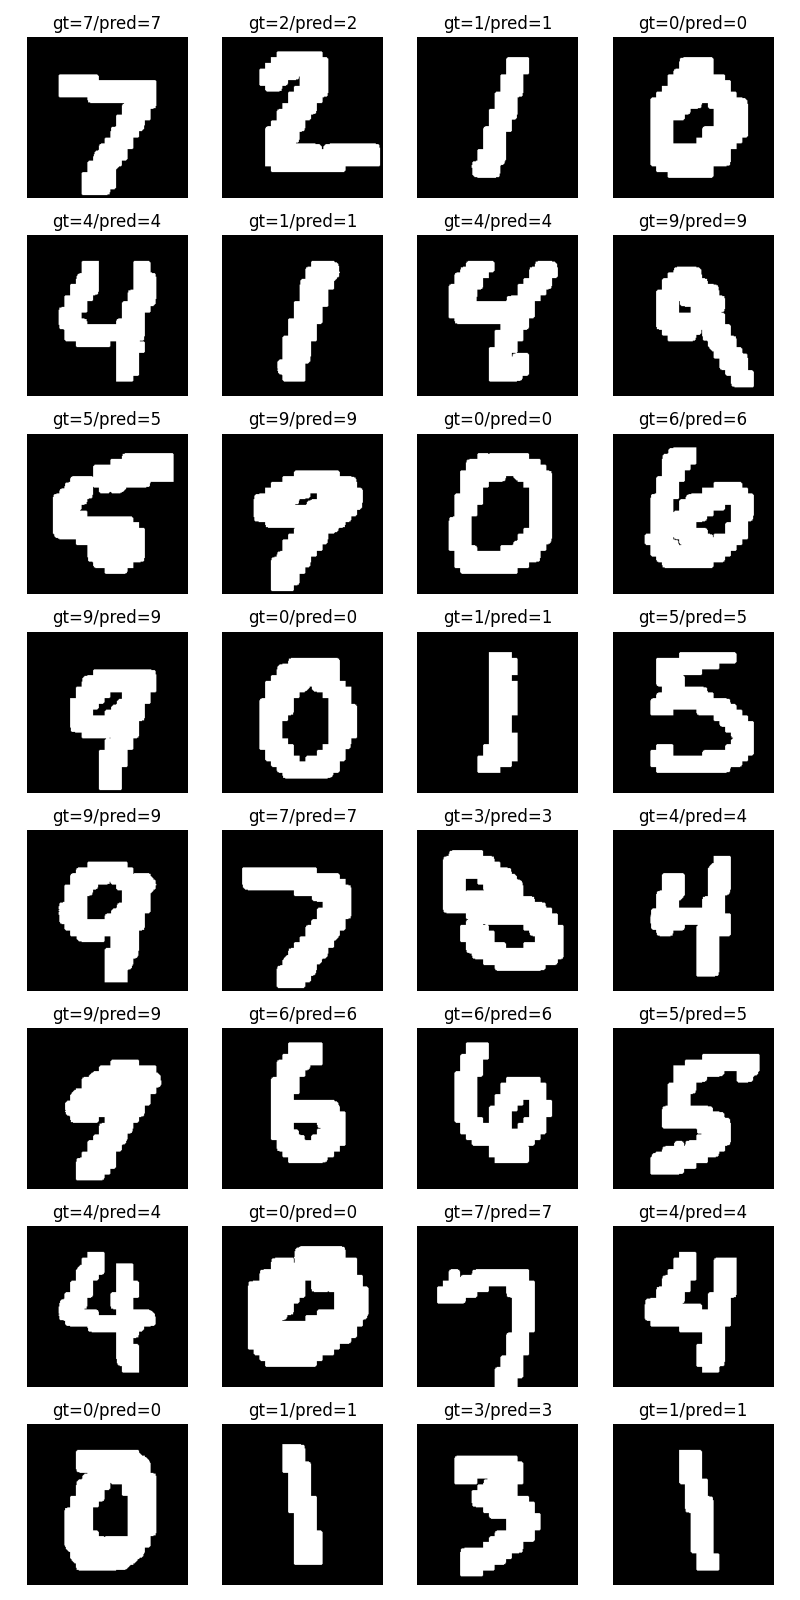

In [23]:
plot_classifications(imgs.permute(0, 2, 3, 1).numpy(), pred_labels, gt_labels)